# Data Visualizations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.precision", 8)

import holoviews as hv
from holoviews import opts, dim
hv.extension('bokeh')
hv.output(size=200)

ModuleNotFoundError: No module named 'holoviews'

## Chord Diagram

Using the bokeh library: https://holoviews.org/reference/elements/bokeh/Chord.html

Chord Diagrams visualize the flux of relationships; thus, a chord diagram is suitable to visualize the frequency of trips between stations located in different San Francisco neighborhoods.

However, if we were to group all of the individual routes between all neighborhoods with a station, the resulting visualization is pretty much unreadable:
![failed chord chart](img/bokeh_plot2.png)

Therefore, we need to narrow the scope of the relationships on display.

## Chord diagram for the busiest top 500 routes in 2019, between Neighborhoods

In [5]:
routesDF = pd.read_csv('inputs/data_lyftSF2019/routes_dataset.csv') 

new_df=routesDF.groupby(['SF_Neigh_start', 'SF_Neigh_end'])['route_C'].sum().reset_index(name='counts').sort_values(by='counts',ascending=False)


routes_N = routesDF.groupby('SF_Neigh_end')[['route_C']].sum()

### Find the Percentage
routes_N['routeN_P'] = (routes_N['route_C'] / routes_N['route_C'].sum()).astype(float).map("{:.2%}".format)
###

routes_N.sort_values(['route_C'],ascending=False).head(10)

,route_C,routeN_P
SF_Neigh_end,,
South of Market,377029,21.01%
Mission Bay,248246,13.84%
Financial District,209531,11.68%
Mission,197713,11.02%
Showplace Square,85883,4.79%
Northern Waterfront,69710,3.89%
Rincon Hill,68077,3.79%
Downtown / Union Square,67508,3.76%
Civic Center,48917,2.73%


In [6]:
chords_df = new_df.head(500)
link = chords_df[['SF_Neigh_start','SF_Neigh_end','counts']].rename(
    columns={'SF_Neigh_start':'source',
             'SF_Neigh_end':'target',
             'route_C':'value'})

chord = hv.Chord(link)
chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('source').str(), 
               labels='index', node_color=dim('index').str()))

:Chord   [source,target]   (counts)

## Heatmaps

### Days of the Week X Months

In [4]:
### Import the dataset ###
master_df = pd.read_csv(r'inputs/data_lyftSF2019/outputs/2019lyftSF_remastered.csv',index_col=[0],float_precision=None)
master_df['duration_min'] = master_df['duration_sec'] // 60

master_df['start_time_day'] = pd.Categorical(master_df['start_time_day'], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],ordered=True)
master_df['start_time_month'] = pd.Categorical(master_df['start_time_month'], categories=['January','February','March','April','May','June','July','August','September','October','November','December'],ordered=True)


index_df = master_df.groupby(['start_time_month', 'start_time_day','start_time_hour']) \
.agg(count=('duration_min', 'size'), mean =('duration_min', 'mean'))

index_df.head()

/home/hp-nunes/anaconda3/envs/TEST/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


count         mean
start_time_month start_time_day start_time_hour                    
January          Monday         0                   88  12.35227273
                                1                   46  37.52173913
                                2                   19  16.47368421
                                3                   18  32.55555556
                                4                   27  24.85185185

### Days of the Week X Hours

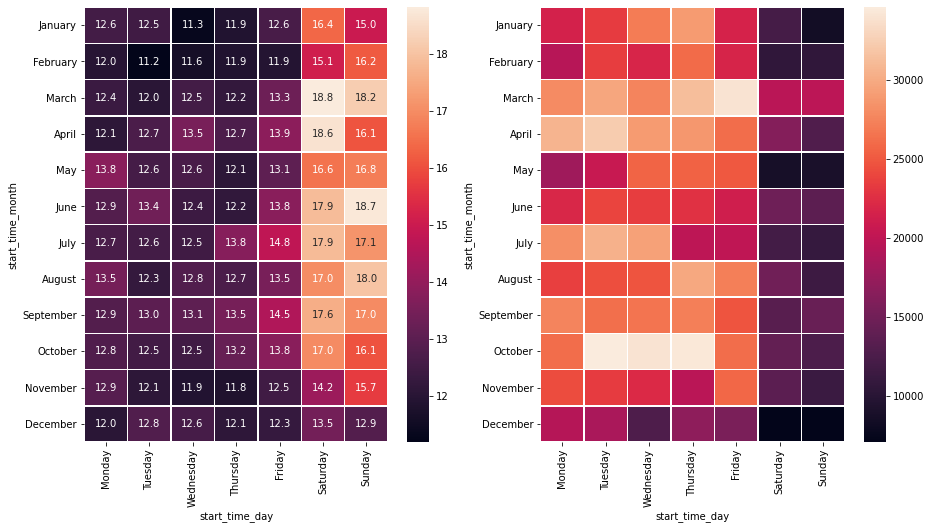

In [5]:
df = index_df.pivot_table(index='start_time_month', columns='start_time_day', values='mean', aggfunc=np.median)
df1 = index_df.pivot_table(index='start_time_month', columns='start_time_day', values='count', aggfunc=np.sum)


fig_dims = (15, 8)
fig, ax = plt.subplots(1,2,figsize=fig_dims)
sns.heatmap(df, annot=True, fmt=".1f",ax=ax[0],linewidths=.5)
sns.heatmap(df1, annot=False, fmt=".1f",ax=ax[1],linewidths=.5)

plt.show()

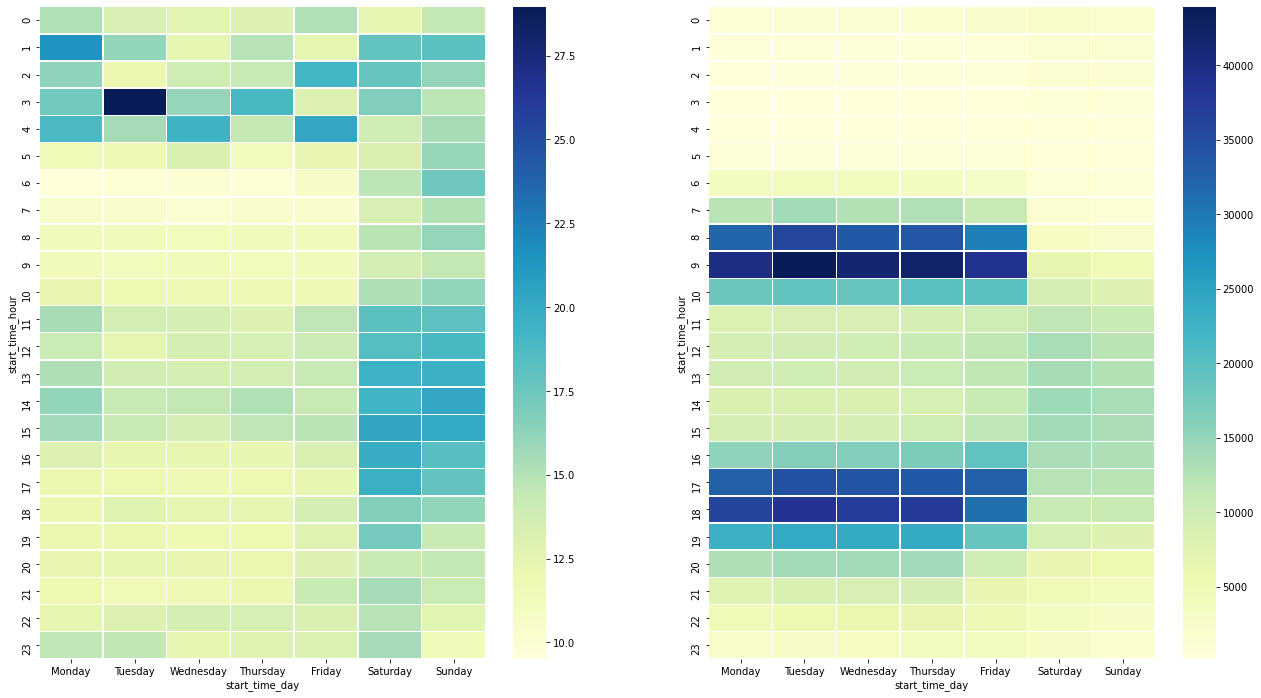

In [6]:
df = index_df.pivot_table(index='start_time_hour', columns='start_time_day', values='mean', aggfunc=np.median)
df1 = index_df.pivot_table(index='start_time_hour', columns='start_time_day', values='count', aggfunc=np.sum)


fig_dims = (22, 12)
fig, ax = plt.subplots(1,2,figsize=fig_dims)
sns.heatmap(df, annot=False, cmap="YlGnBu",ax=ax[0],linewidths=.5)
sns.heatmap(df1, annot=False, cmap="YlGnBu",ax=ax[1],linewidths=.5)

plt.show()

## Visualizing the Distribution

Normalize the duration field into an average of 'trip duration (min) per XYZ variable of time'

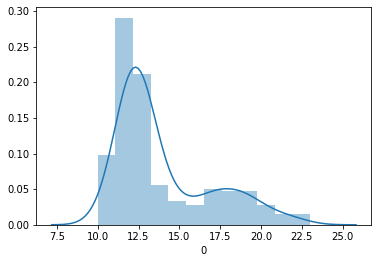

In [7]:
def normalize(dataframe, times): # Sum durations (in sec) and divide by variables of time (count) (day/date/hour/month)
    for time in times:
        d[time] = (dataframe.groupby(time)['duration_sec'].sum() / dataframe.groupby(time)[time].count()) // 60 # Saves each grouping into a new dataframe field
        
        # ref: https://stackoverflow.com/questions/50485911/creating-new-dataframes-in-loop-in-python
        
time = ['date_start','start_time_hour','start_time_day','start_time_month']

d = {}

normalize(master_df, time)

duration_date = pd.DataFrame(d['date_start']).reset_index()

x = duration_date.date_start
y = duration_date[0]

sns.distplot(y)

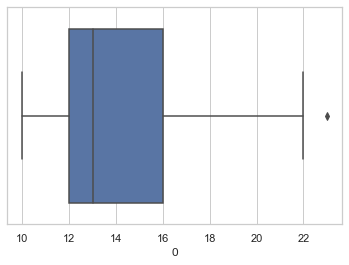

In [8]:
sns.set(style="whitegrid")
sns.boxplot(x=y)

coefficient of determination: 0.5290792871428953


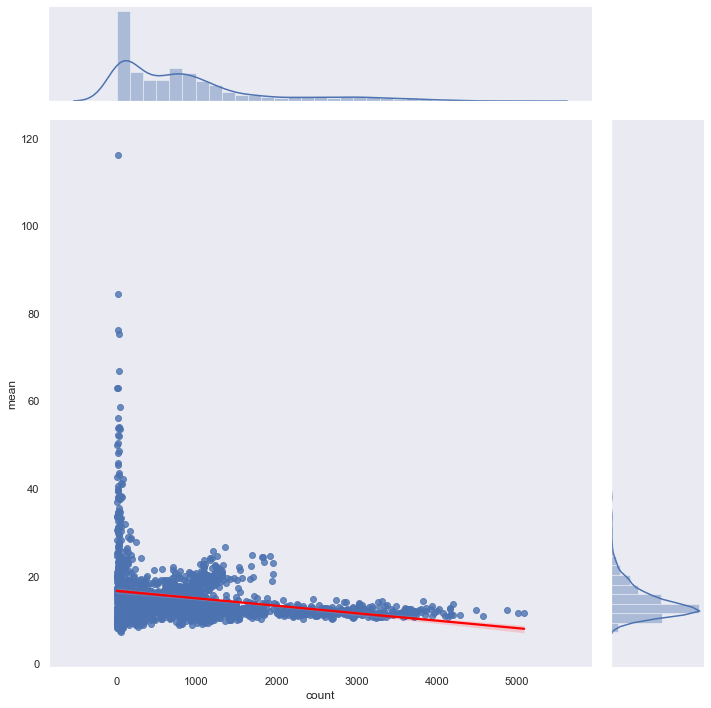

In [9]:
sns.set(style="dark")
sns.jointplot(x="count", y="mean", data=index_df, kind="reg",height=10,
                   joint_kws={'line_kws':{'color':'red'}})

import numpy as np
from sklearn.linear_model import LinearRegression

df = index_df.reset_index()
x = df[['count']].reset_index()
y = df[['mean']].reset_index()
 
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)

## Timeseries

### Average Trip (min) per Hour

/home/hp-nunes/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


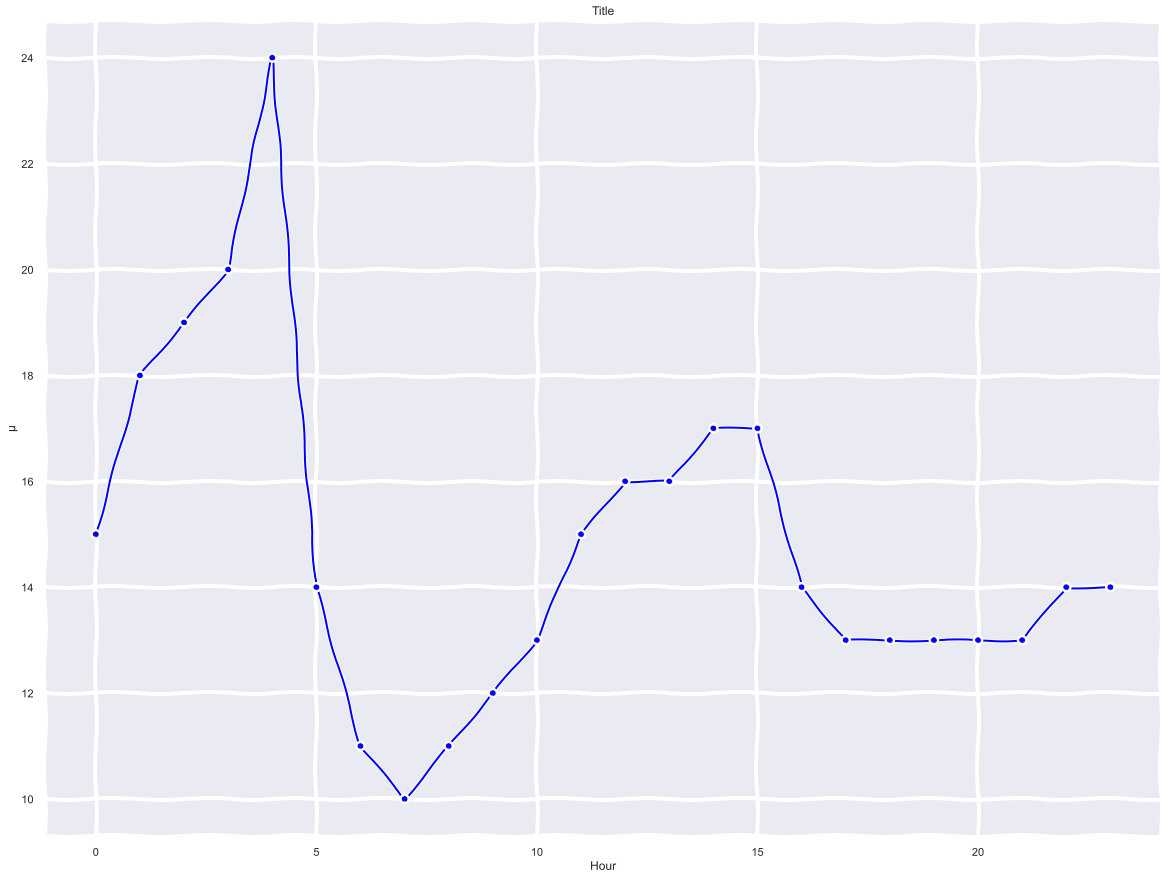

In [10]:
from pylab import *
from matplotlib import *

duration_date = pd.DataFrame(d['start_time_hour']).reset_index()

x = duration_date.start_time_hour
y = duration_date[0]

plt.figure(figsize=(20,15))
with plt.xkcd():
    sns.set_style('darkgrid')
    sns.lineplot(x=x, y=y,marker='o',alpha=1, color='blue')

    ax = pylab.axes()
    ax.set_title("Title")

    ax.set_ylabel('µ')
    ax.set_xlabel('Hour')

### Average Trip (min) per Day

/home/hp-nunes/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


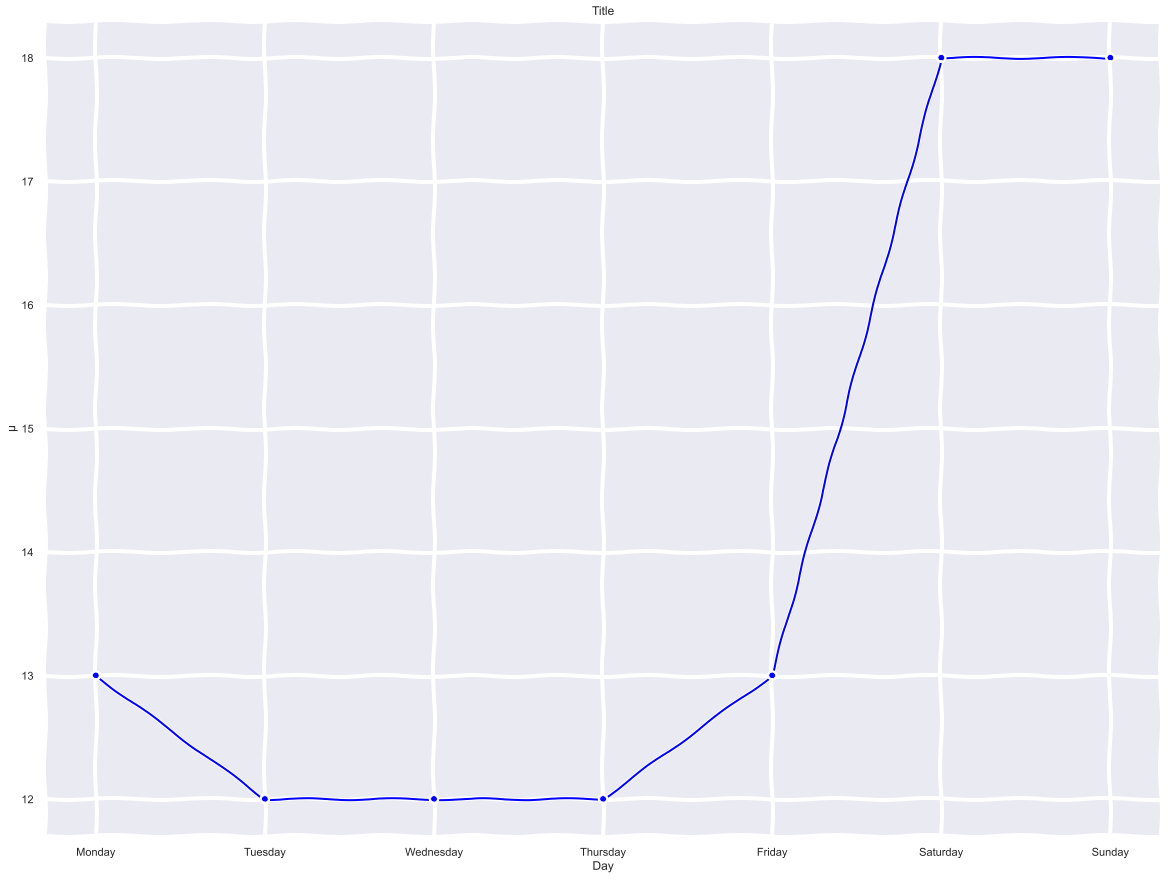

In [11]:
duration_date = pd.DataFrame(d['start_time_day']).reset_index()

x = duration_date.start_time_day
y = duration_date[0]

plt.figure(figsize=(20,15))
with plt.xkcd():
    sns.set_style('darkgrid')
    sns.lineplot(x=x, y=y,marker='o',alpha=1, color='blue')

    ax = pylab.axes()
    ax.set_title("Title")

    ax.set_ylabel('µ')
    ax.set_xlabel('Day')

### Average Trip (min) per Month

/home/hp-nunes/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


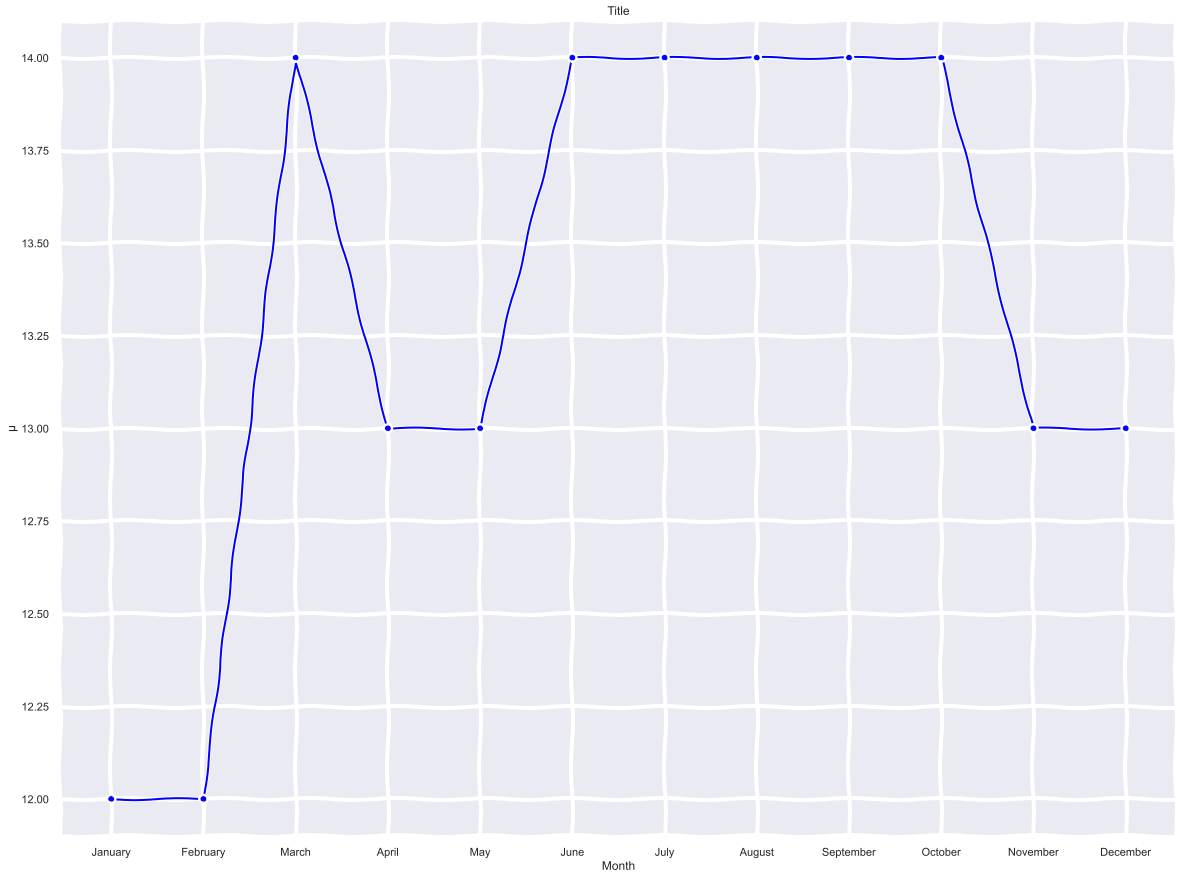

In [12]:
duration_date = pd.DataFrame(d['start_time_month']).reset_index()

x = duration_date.start_time_month
y = duration_date[0]

plt.figure(figsize=(20,15))
with plt.xkcd():
    sns.set_style('darkgrid')
    sns.lineplot(x=x, y=y,marker='o',alpha=1, color='blue')

    ax = pylab.axes()
    ax.set_title("Title")

    ax.set_ylabel('µ')
    ax.set_xlabel('Month')